<a href="https://colab.research.google.com/github/aem226/Reinforcement-Learning-Projects/blob/main/lab10_half_cheetah_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# HalfCheetah: Learn a Dynamics Model from Random Rollouts (Then Validate It)

**Goal:** In this notebook you'll (1) collect random experience tuples \((s_t, a_t, r_t, s_{t+1})\) from `HalfCheetah-v4`, (2) train a neural network to predict **state deltas** \(\Delta s = s_{t+1}-s_t\), and (3) **validate** the model with one-step and multi-step (open-loop) rollouts.

This mirrors the first phase of model-based control (e.g., MPPI): learn a model offline, then use it for planning.



## 0. Requirements

- Python 3.9+
- PyTorch `>= 1.10`
- Gymnasium `>= 0.29`
- MuJoCo with `HalfCheetah-v4` (install `mujoco` and `gymnasium[mujoco]`)

```bash
pip install "gymnasium[mujoco]" mujoco torch matplotlib
```

**Try and understand what RunningNormalizer does.**


In [47]:
pip install "gymnasium[mujoco]" mujoco torch matplotlib

In [48]:

import os, math, random, time
from dataclasses import dataclass
from typing import Tuple
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym

def to_t(x):
    return th.as_tensor(x, dtype=th.float32)

def fanin_init(m):
    if isinstance(m, nn.Linear):
        bound = 1.0 / math.sqrt(m.weight.size(1))
        nn.init.uniform_(m.weight, -bound, +bound)
        nn.init.zeros_(m.bias)

class RunningNormalizer:
    """Feature-wise running mean/std (Welford)."""
    def __init__(self, dim, eps=1e-8):
        self.dim = dim
        self.count = 0
        self.mean = np.zeros(dim, dtype=np.float64)
        self.M2   = np.zeros(dim, dtype=np.float64)
        self.eps  = eps

    def update(self, x: np.ndarray):
        x = np.asarray(x)
        if x.ndim == 1: x = x[None, :]
        for v in x:
            self.count += 1
            d = v - self.mean
            self.mean += d / self.count
            d2 = v - self.mean
            self.M2 += d * d2

    @property
    def var(self):
        if self.count < 2: return np.ones(self.dim, dtype=np.float64)
        return self.M2 / (self.count - 1 + 1e-12)

    @property
    def std(self):
        return np.sqrt(self.var + self.eps)

    def normalize(self, x): return (x - self.mean) / self.std
    def denormalize(self, x): return x * self.std + self.mean

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); th.manual_seed(seed)



## Initializing Environment and Figure Out Observation Structure

`HalfCheetah-v4` exposes observations as `[qpos[1:], qvel[:]]`. The forward velocity is `qvel[0]`, which sits at index `len(qpos[1:])` inside the observation vector. We'll extract that index for later validation/plots. :::: This is important for planning, if we want to know what each state represents


In [49]:

set_seed(42)
env = gym.make("HalfCheetah-v4")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_low = env.action_space.low
act_high = env.action_space.high

# Find start index of qvel inside obs = [qpos[1:], qvel[:]]
nq = env.unwrapped.model.nq
qvel_start = int(nq - 1)
print("obs_dim:", obs_dim, "act_dim:", act_dim, "qvel_start:", qvel_start)


obs_dim: 17 act_dim: 6 qvel_start: 8


## 🧩 Task 1: Prepare the Replay Buffer
**Goal:** Store transitions \((s_t, a_t, s_{t+1})\) and return training pairs \((x, y) = (s_t, a_t, s_{t+1} - s_t)\).

**Instructions:**
- Implement `add()` to record transitions.
- Add a `sample()` method to randomly sample batch of certain size.



In [50]:
# Create the class and create a class object
class Replay:
    def __init__(self, obs_dim, act_dim, capacity=300000):
        self.obs = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.act = np.zeros((capacity, act_dim), dtype=np.float32)
        self.nxt = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.rew = np.zeros((capacity, 1), dtype=np.float32)
        self.term = np.zeros((capacity, 1), dtype=np.float32)
        self.ptr = 0; self.size = 0; self.cap = capacity

    def add(self, s, a, r, sp, term):
        i = self.ptr
        self.obs[i] = s
        self.act[i] = a
        self.rew[i] = r
        self.nxt[i] = sp
        self.term[i] = term
        self.ptr = (self.ptr + 1) % self.cap
        self.size = min(self.size + 1, self.cap)

    def sample(self, batch):
        idx = np.random.randint(0, self.size, size=batch)
        s  = self.obs[idx]
        a  = self.act[idx]
        sp = self.nxt[idx]
        r  = self.rew[idx]
        t  = self.term[idx]
        x = np.concatenate([s, a], axis=-1)
        y = sp - s
        return map(to_t, (x, y, r, t))

replay = Replay(obs_dim, act_dim)



## Task 2. Collect Random Rollouts

- Gather random actions for a number of steps to create our training dataset. Collect data for 100000 steps.
- Call the function and fill the replay buffer


In [27]:

def collect_random(env, replay, steps=10000, seed=42):
    env.reset(seed=seed)
    np.random.seed(seed)

    obs, info = env.reset()
    for step in range(steps):

        a = env.action_space.sample()

        sp, r, term, trunc, info = env.step(a)
        done = term or trunc

        replay.add(obs, a, r, sp, done)


        if done:
            obs, info = env.reset()
        else:
            obs = sp

        if (step + 1) % 10000 == 0:
            print(f"Collected {step + 1} / {steps} steps")

    print(f"✅ Done collecting {steps} random transitions.")


## Task 3. Update normalizers from the collected random data in the replay buffer

We normalize inputs (`[s,a]`) and targets (`Δs = s' - s`) for stable training.


In [51]:

obs_norm = RunningNormalizer(obs_dim)
inp_norm = RunningNormalizer(obs_dim + act_dim)
targ_norm = RunningNormalizer(obs_dim)

# write the function to update the normalizers from the data collected in the buffer
def update_normalizers_from_buffer(replay):
    s  = replay.obs[:replay.size]
    a  = replay.act[:replay.size]
    sp = replay.nxt[:replay.size]

    x = np.concatenate([s, a], axis=-1)
    y = sp - s


    obs_norm.update(s)
    inp_norm.update(x)
    targ_norm.update(y)

update_normalizers_from_buffer(replay)
print("Normalizers ready.")


Normalizers ready.



## Defining the Neural Dynamics Model

We predict **normalized** `Δs` from **normalized** `[s, a]`.
NN parameters:

- initialize a deterministic NN with a ExponentialLR sceduler( that decays the learning rate with epoch)
- width = 200, depth = 3, lr = 1e-3, weight_decay - 1e-5, gamma for scheduler = 0.8
- These are a starting point but not the best parameters.


In [52]:

class DetMLP(nn.Module):
    """Predicts Δstate deterministically."""
    def __init__(self, in_dim, out_dim, width=200, depth=3):
        super().__init__()
        layers = []
        last = in_dim
        for _ in range(depth):
            layers += [nn.Linear(last, width), nn.ReLU()]
            last = width
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
        self.apply(fanin_init)

    def forward(self, x):
        return self.net(x)

in_dim = obs_dim + act_dim
out_dim = obs_dim
model = DetMLP(in_dim, out_dim, width=200, depth=3)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)



## Task 4. Train the Model

We minimize MSE between predicted normalized `Δs` and target normalized `Δs`.

- Train in batches, keep the batch size 256
- Use a learning rate scheduler that decays the learning rate as training progresses. You may use the pytorch utility. See how the learning rate decays with each epoch.
- Train for 30 epochs and plot the training curve. Loss vs epoch.
- Find the best parameters(defined in the previous block)



Epoch 1/30 | Loss = 0.455707
Epoch 2/30 | Loss = 0.419159
Epoch 3/30 | Loss = 0.425413
Epoch 4/30 | Loss = 0.410085
Epoch 5/30 | Loss = 0.405081
Epoch 6/30 | Loss = 0.403451
Epoch 7/30 | Loss = 0.391526
Epoch 8/30 | Loss = 0.388008
Epoch 9/30 | Loss = 0.382962
Epoch 10/30 | Loss = 0.376175
Epoch 11/30 | Loss = 0.368241
Epoch 12/30 | Loss = 0.357505
Epoch 13/30 | Loss = 0.363194
Epoch 14/30 | Loss = 0.353231
Epoch 15/30 | Loss = 0.341903
Epoch 16/30 | Loss = 0.340046
Epoch 17/30 | Loss = 0.339329
Epoch 18/30 | Loss = 0.328847
Epoch 19/30 | Loss = 0.323711
Epoch 20/30 | Loss = 0.316022
Epoch 21/30 | Loss = 0.310164
Epoch 22/30 | Loss = 0.309296
Epoch 23/30 | Loss = 0.301584
Epoch 24/30 | Loss = 0.297960
Epoch 25/30 | Loss = 0.298888
Epoch 26/30 | Loss = 0.290623
Epoch 27/30 | Loss = 0.291436
Epoch 28/30 | Loss = 0.281864
Epoch 29/30 | Loss = 0.280906
Epoch 30/30 | Loss = 0.276202
Training complete.


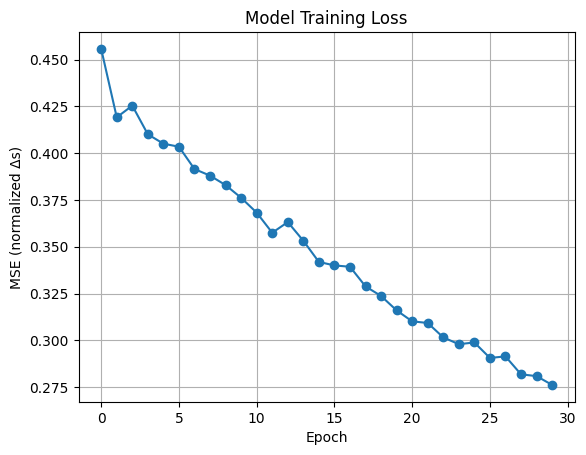

In [61]:
def train_model(model, replay, epochs=30, batch_size=256):
    # optimizer and scheduler
    opt = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.99)
    loss_fn = nn.MSELoss()

    losses = []

    for epoch in range(epochs):
        model.train()
        n_batches = max(1, replay.size // batch_size)
        epoch_loss = 0.0

        for _ in range(n_batches):
            # sample a batch
            x, y, _, _ = replay.sample(batch_size)


            x = inp_norm.normalize(x.numpy())
            y = targ_norm.normalize(y.numpy())

            x = to_t(x)
            y = to_t(y)

            # forward pass
            pred = model(x)
            loss = loss_fn(pred, y)

            # backward pass
            opt.zero_grad()
            loss.backward()
            opt.step()

            epoch_loss += loss.item()


        scheduler.step()

        avg_loss = epoch_loss / n_batches
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} | Loss = {avg_loss:.6f}")

    print("Training complete.")
    return losses


# ---- Train for 30 epochs ----
losses = train_model(model, replay, epochs=30, batch_size=256)

# ---- Plot training curve ----
plt.figure()
plt.plot(losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("MSE (normalized Δs)")
plt.title("Model Training Loss")
plt.grid(True)
plt.show()



ValueError: high <= 0

## Task 5. Validate your model: One-Step and Multi-Step Prediction Error

- Evaluate your trained model on a held-out set of random transitions.
Generate a batch of unseen samples, predict the next-state delta, and compute the one-step MSE.

- Repeat with open-loop rollouts of length k.
Drive both the real environment and the model with the same action sequence, then report how prediction error grows across steps.

One-step MSE: 0.270891


Multi-step rollouts: 100%|██████████| 5/5 [00:00<00:00, 181.51it/s]


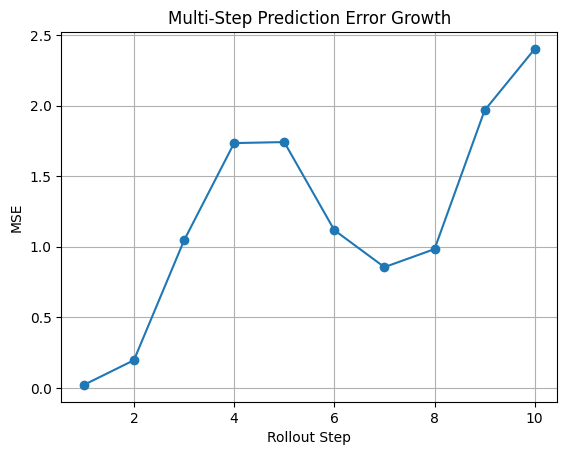

In [62]:
from tqdm import trange

def validate_model(model, env, replay, steps=1000, rollout_horizon=10):
    model.eval()


    # sample unseen transitions from replay
    x, y, _, _ = replay.sample(steps)
    x = x.numpy()
    y = y.numpy()

    # normalize inputs and targets
    x_n = inp_norm.normalize(x)
    y_n = targ_norm.normalize(y)


    with th.no_grad():
        pred_n = model(to_t(x_n)).cpu().numpy()
        pred = targ_norm.denormalize(pred_n)

    one_step_mse = np.mean((pred - y) ** 2)
    print(f"One-step MSE: {one_step_mse:.6f}")

    rollout_errors = []

    for _ in trange(5, desc="Multi-step rollouts"):
        obs, info = env.reset()
        obs_model = obs.copy()

        ep_errors = []

        for t in range(rollout_horizon):

            action = env.action_space.sample()

            # real next state
            next_real, _, term, trunc, _ = env.step(action)
            done = term or trunc

            # model prediction
            inp = np.concatenate([obs_model, action])[None, :]
            inp_n = inp_norm.normalize(inp)
            with th.no_grad():
                delta_pred_n = model(to_t(inp_n)).cpu().numpy()
                delta_pred = targ_norm.denormalize(delta_pred_n)
            next_model = obs_model + delta_pred[0]

            # compute error between real vs predicted next state
            err = np.mean((next_model - next_real) ** 2)
            ep_errors.append(err)

            # advance both envs
            obs = next_real
            obs_model = next_model

            if done:
                break

        rollout_errors.append(ep_errors)


    rollout_errors = np.array(rollout_errors)
    avg_error = np.mean(rollout_errors, axis=0)

    plt.figure()
    plt.plot(range(1, len(avg_error)+1), avg_error, marker='o')
    plt.xlabel("Rollout Step")
    plt.ylabel("MSE")
    plt.title("Multi-Step Prediction Error Growth")
    plt.grid(True)
    plt.show()

    return one_step_mse, avg_error

one_step_mse, multi_err = validate_model(model, env, replay, steps=1000, rollout_horizon=10)




## Task 6. Visualize Rollout Trajectories

**Setup**
Call model.eval() so gradients stay off.
Reset the env with the provided seed; keep a copy of the initial observation.


**Choose actions**
Pre-sample k actions from env.action_space.sample() so the real system and the model rollout see the same sequence.

**Roll forward**
For each action:
Step the real env (env.step(a)), append the new observation.
For the model path:
Build [s_model, a], normalize via inp_norm.normalize, turn into a tensor with to_t.
Run the network, de-normalize with targ_norm.denormalize, add to the last model state, append.
Stop early if the env terminates or truncates.

**Plot**
Plot the real trajectory as one line, model trajectory as another.



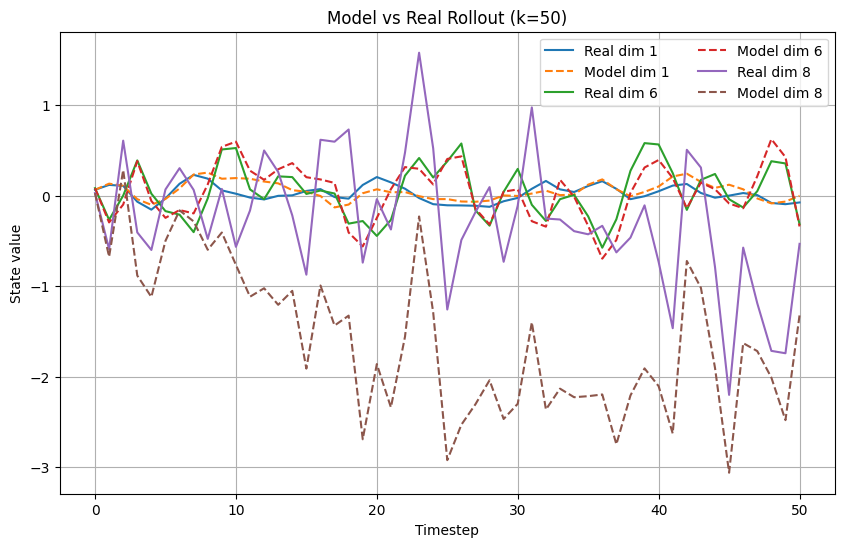

In [63]:
def visualize_rollout(env, model, k=50, dims=(0, 5, 10), seed=2025):
    model.eval()
    np.random.seed(seed)
    th.manual_seed(seed)


    obs_real, info = env.reset(seed=seed)
    obs_model = obs_real.copy()

    real_traj = [obs_real.copy()]
    model_traj = [obs_model.copy()]


    actions = [env.action_space.sample() for _ in range(k)]


    for t in range(k):
        # Real environment step
        next_real, _, term, trunc, _ = env.step(actions[t])
        done = term or trunc
        real_traj.append(next_real.copy())

        # Model prediction path
        inp = np.concatenate([obs_model, actions[t]])[None, :]
        inp_n = inp_norm.normalize(inp)

        with th.no_grad():
            delta_pred_n = model(to_t(inp_n)).cpu().numpy()
            delta_pred = targ_norm.denormalize(delta_pred_n)
        next_model = obs_model + delta_pred[0]
        model_traj.append(next_model.copy())

        # Update for next step
        obs_model = next_model
        obs_real = next_real

        if done:
            break

    real_traj = np.array(real_traj)
    model_traj = np.array(model_traj)


    plt.figure(figsize=(10, 6))
    for d in dims:
        plt.plot(real_traj[:, d], label=f"Real dim {d}")
        plt.plot(model_traj[:, d], '--', label=f"Model dim {d}")
    plt.xlabel("Timestep")
    plt.ylabel("State value")
    plt.title(f"Model vs Real Rollout (k={k})")
    plt.legend(ncol=2)
    plt.grid(True)
    plt.show()



visualize_rollout(env, model, k=50, dims=(1, 6, 8))





## 9. Answer the questions :

1. How good is your model?

The model performs reasonably well for short-term predictions but struggles to stay accurate over longer rollouts. In the plot, the model-predicted trajectories (dashed lines) generally follow the overall trend of the real trajectories (solid lines) for the first few steps, especially in lower-index dimensions like 1 and 6. However, as time progresses, the model begins to drift particularly in dimension 8, where the predictions diverge significantly from the real values.


2. Is this training enough for planning, or do we need continual training?

This model needs continual training because it was only trained once on random samples, so it doesn’t keep improving as it encounters new states. During planning or control, the system visits areas of the environment it hasn’t seen before, causing prediction errors to grow. By continually training, meaning we keep adding new data from the model’s own rollouts and updating it

3. How is this system different from the mountain car problem? Why can't we learn this in one episode?

The HalfCheetah system is much more complex than the Mountain Car problem. Mountain Car only has two state variables (position and velocity) and one action, so it’s easy to cover its entire state space in a single run. HalfCheetah, on the other hand, has many joints and high-dimensional states that interact in nonlinear ways. One episode only explores a small part of this huge state space, so the model doesn’t see enough examples to learn the full dynamics.


4. Why do we use a runningnormalizer instead of a static normalizer? Think about the nature of the algorithm taught in class.

By using a running normalizer because the data distribution changes as the model keeps collecting new rollouts. Early in training, the agent’s movements are small and random, but later it reaches faster and more varied states. A static normalizer fixed at the beginning would quickly become outdated, causing unstable learning. A running normalizer updates its mean and standard deviation continuously, keeping the inputs and targets properly scaled as new data comes in.


